#1. Random Forest Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Load the data
df = pd.read_csv('bikeshare.csv')


Test/Train Split

2.1 Default Features

In [ ]:
# 1. Define feature space
features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'notbizday',
           'weathersit', 'temp', 'hum', 'windspeed']

#not including date
X = df[features]
y = df['cnt']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

2.2-2.3Test Set/y-hat/dataframe/predictions

In [ ]:
# Train initial RF model
rf = RandomForestRegressor(random_state=1000)
rf.fit(X_train, y_train)

# Make predictions
y_hat = rf.predict(X_test)

# Create predictions dataframe
df_predictions = pd.DataFrame({
    'y_test': y_test,
    'y_hat': y_hat
})



2.4 Scatterplot

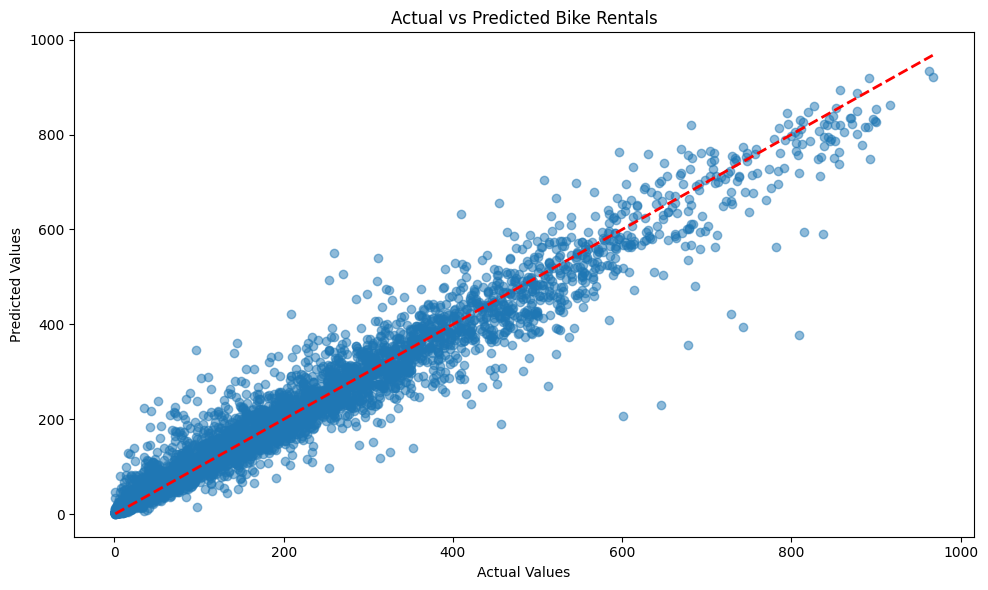

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_hat, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Bike Rentals')
plt.tight_layout()
plt.show()

2.4 - Visual Satisfaction
Positive aspects:
There's a strong positive linear relationship between actual and predicted values, as shown by the red dashed line
The points cluster fairly tightly around the diagonal line, indicating good prediction accuracy
The model appears to work across the full range of values (from 0 to 1000 rentals)

Areas of potential concern:

There's some heteroscedasticity visible - the spread of predictions seems to increase for higher actual values
There are a few outliers, particularly visible in the mid-range (around 400-600 actual values) where predictions deviate significantly
The model appears to slightly underpredict at very high values (800+ rentals) as more points fall below the diagonal line in that region

2.5 R-squared and RMSE

In [ ]:
# Calculate metrics
r2 = r2_score(y_test, y_hat)
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
print(f"Initial Model R² Score: {r2:.4f}")
print(f"Initial Model RMSE: {rmse:.4f}")


Initial Model R² Score: 0.9488
Initial Model RMSE: 41.8249


3. Tuning Hyperparameters

In [ ]:
# 3. Hyperparameter tuning
my_param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, None]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=1000),
                         my_param_grid,
                         cv=5,
                         scoring='r2')
grid_search.fit(X_train, y_train)

# Best model predictions
best_rf = grid_search.best_estimator_
y_hat_best = best_rf.predict(X_test)
r2_best = r2_score(y_test, y_hat_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_hat_best))

print("\nBest Parameters:", grid_search.best_params_)
print(f"Best Model R² Score: {r2_best:.4f}")
print(f"Best Model RMSE: {rmse_best:.4f}")


Best Parameters: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Best Model R² Score: 0.9046
Best Model RMSE: 57.0705


No, the hyperparameter tuning actually resulted in slightly worse performance. The R² decreased from 0.9488 to 0.9046, and the RMSE increased from 41.82 to 57.07.
Regarding the tree structure (whether Random Forest is using a small or bushy tree):
The model is using a bushy tree because:

The best max_depth parameter is None, which means trees are allowed to grow until all leaves are pure or contain less than 2 samples
This indicates the model is creating deep, fully-grown trees rather than shallow/small trees that would result from a low max_depth value (like 10, which was the other option in the grid)

We know this from looking at the best_params where max_depth: None was selected over max_depth: 10. This suggests that the model benefits from deeper, more complex trees to capture the relationships in the data, even though it didn't improve overall performance compared to the default parameters.

In [ ]:
# CV score
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
print(f"\nCross-validation R² scores: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train RF with OOB score
rf_oob = RandomForestRegressor(random_state=1000, oob_score=True, **grid_search.best_params_)
rf_oob.fit(X_train, y_train)
print(f"OOB R² Score: {rf_oob.oob_score_:.4f}")


Cross-validation R² scores: 0.8932 (+/- 0.0029)
OOB R² Score: 0.9022


4.Cross Validation and OOB

Comparing the results:

The scores are fairly close to each other (difference of about 0.009)
OOB estimate (0.9022) is slightly higher than the CV estimate (0.8932)
The CV result has a small standard deviation (±0.0029), indicating stable performance across folds
Both methods suggest good model performance with R² values around 0.90

The similarity between CV and OOB estimates suggests that both methods are providing reliable performance estimates. This is expected since both methods aim to assess how well the model generalizes to unseen data, just using different approaches. The small difference between them (less than 1%) adds confidence to our performance assessment.
The tight standard deviation in the CV scores (±0.0029) also indicates that the model's performance is consistent across different subsets of the data.

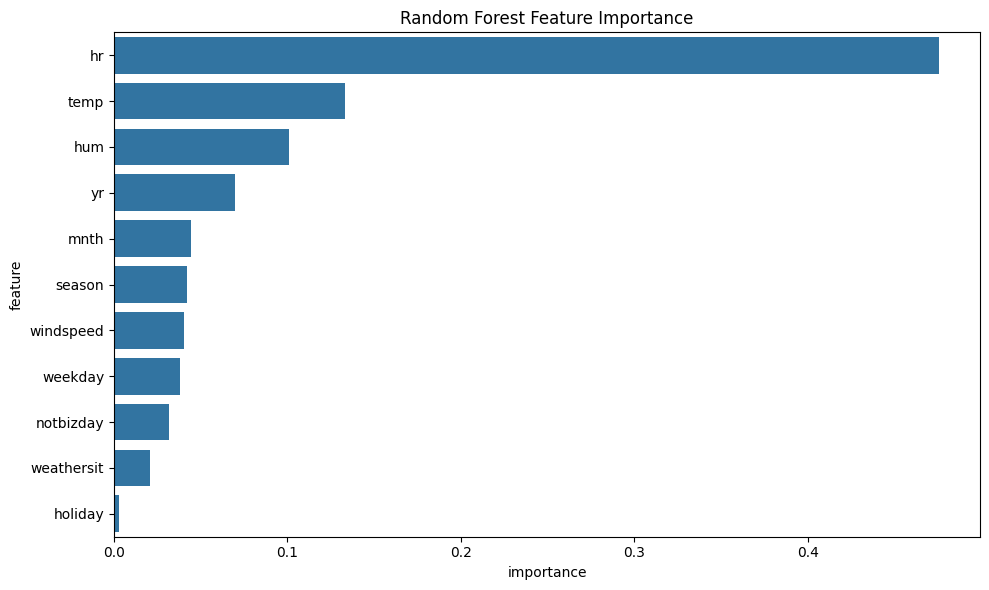


Top 5 Important Features (RF):
  feature  importance
3      hr    0.475580
8    temp    0.133231
9     hum    0.100916
1      yr    0.069944
2    mnth    0.044356

Top 5 Significant Features (Linear Regression):
   feature  coefficient
1       yr    80.355354
8     temp    54.331227
9      hum    37.740460
4  holiday    23.988551
0   season    19.344152


In [ ]:
# 5. Feature Importance Comparison
# RF Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# Linear Regression for comparison
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_coef = pd.DataFrame({
    'feature': features,
    'coefficient': np.abs(lr.coef_)
}).sort_values('coefficient', ascending=False)

print("\nTop 5 Important Features (RF):")
print(feature_importance.head())
print("\nTop 5 Significant Features (Linear Regression):")
print(lr_coef.head())

Key differences:

A notable variable that was important in RF but not in top 5 significant variables in linear regression is "hr" (hour). This is the most interesting case as it's the #1 most important feature in RF but doesn't appear in the top 5 for linear regression at all.

What's going on here?
This difference likely occurs because:

Random Forest can capture non-linear relationships and complex interactions between features, while linear regression assumes linear relationships
The "hr" variable likely has a non-linear relationship with bike rentals (e.g., peak hours during commute times, low usage at night) that RF can capture well through its tree-based structure
Linear regression might struggle to capture this cyclic, non-linear pattern of hourly usage with its linear coefficients, thus underestimating its importance
RF's importance is based on how much each feature improves prediction when used in decision splits, while linear regression's significance is based on the statistical significance of linear coefficients

#2. Random Forest Classification

1. Binary Target Variable

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df['overload'] = (df['cnt'] > 500).astype(int)
overload_props = df['overload'].value_counts(normalize=True)
print("\n1. Target Variable Distribution:")
print(overload_props)


1. Target Variable Distribution:
overload
0    0.926405
1    0.073595
Name: proportion, dtype: float64


The data is extremely imbalanced as 92.64% of the cases are being classified as non-overload vs 7.35% overload.

2. Feature Space and Test/Train Split

In [ ]:
# 2. Define feature space and split data
feature_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'notbizday',
                'weathersit', 'temp', 'hum', 'windspeed']
X = df[feature_cols]
y = df['overload']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

3.1 and 3.2

In [ ]:
# 3. Train RF Model and evaluate
rf = RandomForestClassifier(random_state=1000)
rf.fit(X_train, y_train)

# Generate predictions
y_hat_probs = rf.predict_proba(X_test)[:, 1]
y_hat = rf.predict(X_test)


3.3 Histogram

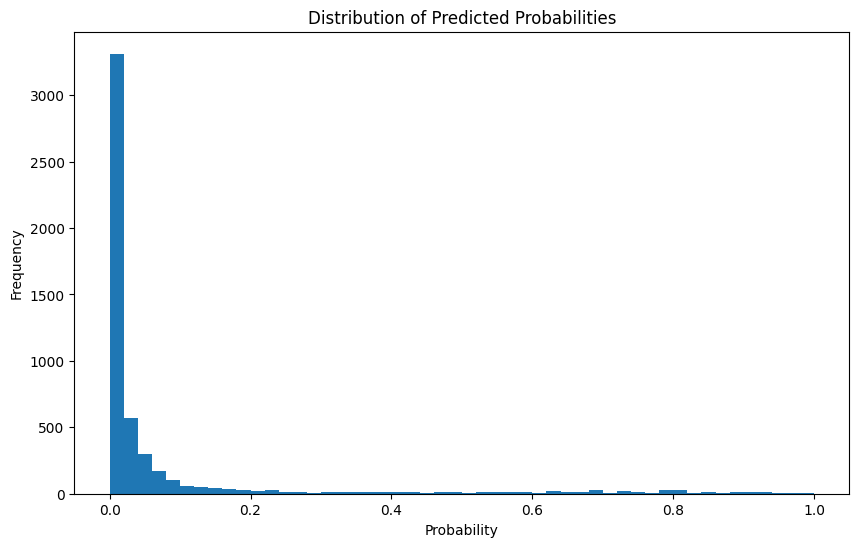

In [ ]:
# Plot probability histogram
plt.figure(figsize=(10, 6))
plt.hist(y_hat_probs, bins=50)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

Strong Concentration Near Zero:
There is a very large spike near probability 0.0
Around 3,000 instances have predicted probabilities close to zero
This indicates the model is very confident in predicting the majority class (no overload) for most cases


Long Right Tail:
The distribution has a long but very thin tail extending toward probability 1.0
Much smaller frequencies of predictions with higher probabilities
Very few cases where the model predicts high probability of overload


Probability Thresholds:
The model appears to rarely predict probabilities above 0.2-0.3
There doesn't appear to be a strict threshold where the model always predicts positive or negative
However, the model is heavily biased toward predicting the negative class (no overload)

This distribution makes sense given what we know about the imbalanced nature of our target variable (only about 7.4% overload cases). The model has learned this imbalance and is generally conservative about predicting overload situations, which is reflected in the probability distribution.

3.4 Classification Report

In [ ]:
# Classification report and confusion matrix
print("\n3. Model Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_hat))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_hat))


3. Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4819
           1       0.89      0.71      0.79       395

    accuracy                           0.97      5214
   macro avg       0.93      0.85      0.89      5214
weighted avg       0.97      0.97      0.97      5214


Confusion Matrix:
[[4784   35]
 [ 113  282]]


True Negatives (TN): 4784 (correctly predicted no-overload)
False Positives (FP): 35 (incorrectly predicted overload)
False Negatives (FN): 113 (missed overload cases)
True Positives (TP): 282 (correctly predicted overload)

Do I trust the accuracy of the model? Why?
No, I would not fully trust the 97% accuracy for this model because:

Class Imbalance Issue:
The high accuracy is heavily influenced by the majority class performance.
The model performs significantly worse on the minority class (overload cases).
The recall for overload cases is only 0.71, meaning we miss 29% of actual overload situations.


Business Context:
Missing overload situations (False Negatives) could be more costly than false alarms.
The 113 missed overload cases could lead to system disruptions.
The model's high accuracy is misleading given the business requirement.

4. Tuning Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

my_param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, None]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=1000),
                         my_param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("\n4. Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)



4. Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
Best Score: 0.9739416358405262


The best parameters found were:
- criterion: 'entropy'
- max_depth: None
- max_features: 'log2'
- n_estimators: 100

**Model Performance Improvement:**
- The best score achieved is approximately 0.974 (97.4%)
- Compared to the original model's accuracy of 0.97, there was a slight improvement in performance (about 0.4 percentage points)
- However, this improvement is relatively modest, suggesting that the default parameters were already performing reasonably well

**Tree Structure Analysis:**
The Random Forest is using "bushy" (deep) trees because:

1. **max_depth: None**
- This parameter allows trees to grow to their full depth without restriction
- Trees will continue splitting until they reach pure leaf nodes or cannot split further
- This indicates the model benefits from complex decision boundaries and detailed patterns in the data

2. **How do we know it's using bushy trees?**
- The max_depth parameter of None means there's no artificial limit on tree depth
- Trees can grow as deep as needed to capture all patterns in the data
- This contrasts with the alternative option in the grid (max_depth=10) which would have created smaller, more constrained trees
- The fact that the model performed better with None rather than 10 suggests that deeper trees are beneficial for this problem

Other parameter insights:
- The entropy criterion was preferred over gini for split quality
- log2 was chosen for max_features, meaning each split considers log2(n_features) features
- 100 estimators was sufficient (no need for 200 trees)

This configuration suggests that the model benefits from:
1. Deep, detailed decision trees
2. Information gain-based splitting (entropy)
3. A moderate number of features considered at each split (log2)

The use of bushy trees might also explain why the model has high accuracy but potentially overfits to the majority class, as seen in the imbalanced performance metrics from the previous question.

5. Cross Validation and OOB

In [ ]:
# CV score
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
print("\n5. Cross-validation scores:", cv_scores.mean())

# OOB score
rf_oob = RandomForestClassifier(oob_score=True, random_state=1000)
rf_oob.fit(X_train, y_train)
print("OOB score:", rf_oob.oob_score_)


5. Cross-validation scores: 0.9719687628442252
OOB score: 0.9718043567612001


The similarity between CV and OOB scores suggests:

The model is stable across different subsets of the data
The Random Forest's internal OOB estimate is reliable
The performance estimates are likely representative of true model performance


Both scores being very high (97.2%) suggests:

The model is performing extremely well at the classification task
However, given such high scores, it would be worth checking if there might be data leakage or if the target variable is highly predictable from the features

6. Balanced Random Forest

In [ ]:
balanced_rf = RandomForestClassifier(class_weight='balanced', random_state=1000)
balanced_rf.fit(X_train, y_train)
y_hat_balanced = balanced_rf.predict(X_test)

print("\n6. Balanced RF Performance:")
print(classification_report(y_test, y_hat_balanced))


6. Balanced RF Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4819
           1       0.89      0.73      0.80       395

    accuracy                           0.97      5214
   macro avg       0.93      0.86      0.89      5214
weighted avg       0.97      0.97      0.97      5214



The recall improve 0.02 in the minority class which makes sense. Typically, balancing the data helps improve the performance for the minority class because the model gets more exposure to those examples during training. It is important to note that the improvement is small, but an improvement none the less.

The majority class didn't change which is a good sign! This means that the balancing didn't hurt the majority class's performance. The minority class's improvement wasn't large enough to create a trade-off.  



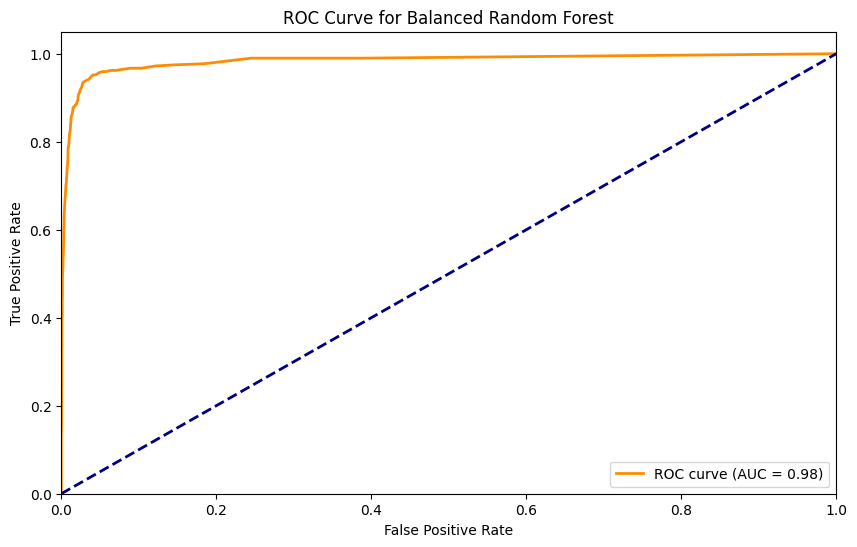

In [ ]:
# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_test, balanced_rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Balanced Random Forest')
plt.legend(loc="lower right")
plt.show()

Can we trust the AUC? No. Despite the fact that we did "deal with our imbalanced data", our recall for the minority class was very small. It was definitely not large enough to truly balace the data. The AUC treats errors in both classes equally important, which for balanced data sets is a good thing. In an unbalanced data set, the weights of the errors must also be unbalanced.

8. Feature Importance

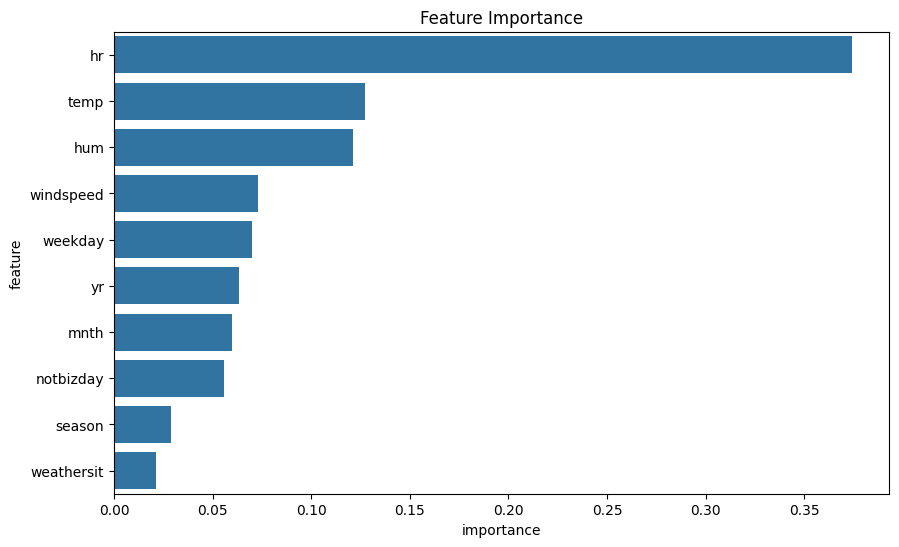


8. Top 5 Important Features:
      feature  importance
3          hr    0.374257
8        temp    0.127064
9         hum    0.121088
10  windspeed    0.073016
5     weekday    0.070042


In [ ]:
importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances.head(10))
plt.title('Feature Importance')
plt.show()

print("\n8. Top 5 Important Features:")
print(importances.head())

Personally, I believe that the top five features, and my explanations as to why, that would be the most important are as follows:

1.Hour - This would be one of the most important features to consider. Rush-hour times like 7-9-ish AM and 4:30-6:30-ish PM, would probably have a spike in demand for bike rentals. Super early in the morning or the evening, and even the middle of the night probably won't have a high demand.

2.Temperature - This is another crucial feature to consider. If it is super cold, or super hot, the demand is going to drop. People aren't going to want to go for a bike ride in un-favorable weather conditions.

3.Weathersit - This goes along with temperature. People will be less likely to bike in un-favorable weather conditions. Some weather conditions could event prevent people from biking like a blizzard, a really bad rainstorm, etc.

4.Notbizday - This one could potentially be a big factor depending on who the clientelle is. If the majority of people rent a bike for transportation reasons, the demand for bikes on a weekend could be a lot smaller compared to a weekday. If people are renting bikes for fun, then the demand on a weekend could be higher than a weekday.

5.Month - This goes along with temperature, weather situation. Certain months are prone to certain temperatures/weathers. For example, January is more of a cold/snowy month compared to July which is hot/sunny. Unfavorable temperature/weather situations will result in a lower demand.

The systems findings are not 100% consistent with common sense. Hour and temperature are at the top of both lists. Weekday is very similar to notbizday. Weekday would probably be a better way to track patterns compared to notbizday. Humidity and windspeed are similar to temperature and weathersit. The main difference is that humidity and windspeed are probably less likely to play a role in whether someone wants to rent a bike or not compared to weather situations.

# Boosting Classification

In [ ]:
# Import all classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Train and evaluate models
# 1. Random Forest (baseline)
rf = RandomForestClassifier(random_state=1000)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_f1 = f1_score(y_test, rf_pred)

# 2. AdaBoost
ada = AdaBoostClassifier(random_state=1000)
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)
ada_f1 = f1_score(y_test, ada_pred)

# 3. Gradient Boosting
gbm = GradientBoostingClassifier(random_state=1000)
gbm.fit(X_train, y_train)
gbm_pred = gbm.predict(X_test)
gbm_f1 = f1_score(y_test, gbm_pred)

# 4. XGBoost
xgb = XGBClassifier(random_state=1000, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_f1 = f1_score(y_test, xgb_pred)

# Compile and display results
results = pd.DataFrame({
    'Model': ['Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'F1 Score': [rf_f1, ada_f1, gbm_f1, xgb_f1]
})

print("\nModel F1 Scores:")
print(results.sort_values('F1 Score', ascending=False))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:45:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model F1 Scores:
               Model  F1 Score
3            XGBoost  0.861619
0      Random Forest  0.792135
2  Gradient Boosting  0.778098
1           AdaBoost  0.603318


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Import all classifiers and time their execution and performance
# 1. Random Forest (baseline)
start_time = time.time()
rf = RandomForestClassifier(random_state=1000)
rf.fit(X_train, y_train)
rf_time = time.time() - start_time
rf_pred = rf.predict(X_test)
rf_f1 = f1_score(y_test, rf_pred)

# 2. AdaBoost
start_time = time.time()
ada = AdaBoostClassifier(random_state=1000)
ada.fit(X_train, y_train)
ada_time = time.time() - start_time
ada_pred = ada.predict(X_test)
ada_f1 = f1_score(y_test, ada_pred)

# 3. Gradient Boosting
start_time = time.time()
gbm = GradientBoostingClassifier(random_state=1000)
gbm.fit(X_train, y_train)
gbm_time = time.time() - start_time
gbm_pred = gbm.predict(X_test)
gbm_f1 = f1_score(y_test, gbm_pred)

# 4. XGBoost
start_time = time.time()
xgb = XGBClassifier(random_state=1000, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_time = time.time() - start_time
xgb_pred = xgb.predict(X_test)
xgb_f1 = f1_score(y_test, xgb_pred)

# Compile results into a DataFrame
results = pd.DataFrame({
    'Model': ['Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'F1 Score': [rf_f1, ada_f1, gbm_f1, xgb_f1],
    'Execution Time': [rf_time, ada_time, gbm_time, xgb_time]
})

# Display rankings
print("\nRanking by performance (F1 Score):")
print(results.sort_values('F1 Score', ascending=False))

print("\nRanking by execution speed (seconds):")
print(results.sort_values('Execution Time'))

# Determine overall winner based on balance of performance and speed
# Calculate normalized scores (0-1 scale) for both metrics
results['F1_normalized'] = (results['F1 Score'] - results['F1 Score'].min()) / (results['F1 Score'].max() - results['F1 Score'].min())
results['Speed_normalized'] = 1 - (results['Execution Time'] - results['Execution Time'].min()) / (results['Execution Time'].max() - results['Execution Time'].min())

# Calculate combined score (equal weight to performance and speed)
results['Combined_Score'] = (results['F1_normalized'] + results['Speed_normalized']) / 2

print("\nOverall ranking (combining performance and speed):")
print(results.sort_values('Combined_Score', ascending=False)[['Model', 'F1 Score', 'Execution Time', 'Combined_Score']])

# Identify the winner
winner = results.loc[results['Combined_Score'].idxmax(), 'Model']
print(f"\nOverall winner: {winner} - best balance of performance and speed")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Ranking by performance (F1 Score):
               Model  F1 Score  Execution Time
3            XGBoost  0.861619        0.157291
0      Random Forest  0.792135        0.846308
2  Gradient Boosting  0.778098        1.278731
1           AdaBoost  0.603318        0.410379

Ranking by execution speed (seconds):
               Model  F1 Score  Execution Time
3            XGBoost  0.861619        0.157291
1           AdaBoost  0.603318        0.410379
0      Random Forest  0.792135        0.846308
2  Gradient Boosting  0.778098        1.278731

Overall ranking (combining performance and speed):
               Model  F1 Score  Execution Time  Combined_Score
3            XGBoost  0.861619        0.157291        1.000000
0      Random Forest  0.792135        0.846308        0.558296
1           AdaBoost  0.603318        0.410379        0.387160
2  Gradient Boosting  0.778098        1.278731        0.338326

Overall winner: XGBoost - best balance of performance and speed


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:45:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
